In [21]:
from sklearn.datasets import make_blobs
import numpy as np
from keras.models import Sequential, Model
from keras_uncertainty.layers import StochasticDropout, SamplingSoftmax
from keras_uncertainty.models import DisentangledStochasticClassifier, StochasticClassifier
from keras.layers import Dense, Input, Dropout
from keras_uncertainty.utils import numpy_entropy
import matplotlib.pyplot as plt

import sys

sys.path.insert(1, '../')


In [24]:
X, y = make_blobs(n_samples=500, n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=0)
BATCH_SIZE = 256
NUM_SAMPLES = 100

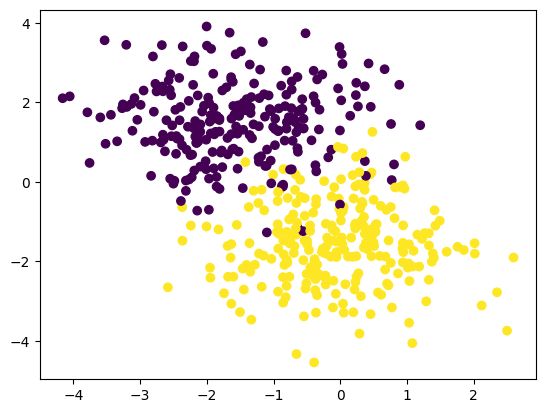

In [25]:
plt.scatter(X[:,0], X[:, 1], c=y)

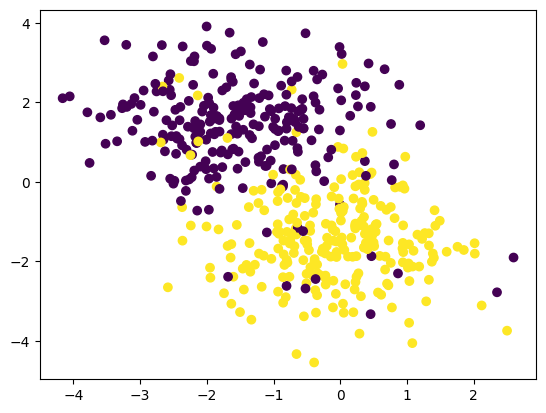

In [26]:
from sklearn.utils import shuffle

def partial_shuffle_dataset(X, y, percentage):
    X_noisy, y_noisy = shuffle(X, y)
    np.random.shuffle(y_noisy[:int(len(y_noisy) * percentage)])
    X_noisy, y_noisy = shuffle(X_noisy, y_noisy)
    return X_noisy, y_noisy

X_noisy, y_noisy = partial_shuffle_dataset(X, y, percentage=0.1)
plt.scatter(X_noisy[:,0], X_noisy[:, 1], c=y_noisy)

In [27]:
noises = np.arange(0, 1, 0.1)

In [40]:
from disentanglement.models.architectures import get_blobs_dropout_architecture
from disentanglement.models.entropy_models import mutual_information, expected_entropy, \
    train_entropy_model
from disentanglement.models.multi_head_models import uncertainty, \
    train_disentangle_model
from disentanglement.settings import BATCH_SIZE, NUM_SAMPLES, TEST_MODE
from tqdm import tqdm
from sklearn.metrics import accuracy_score


X_test, y_test = make_blobs(n_samples=200, n_features=2, centers=[[-1.5, 1.5],[0, -1.5]], random_state=1)



disentangling_accuracies = []
disentangling_aleatorics = []
disentangling_epistemics = []

entropy_accuracies = []
entropy_aleatorics = []
entropy_epistemics = []

epochs = 50
architecture_func = get_blobs_dropout_architecture
n_classes = 2

for noise in tqdm(noises):
    X_noisy, y_noisy = partial_shuffle_dataset(X, y, percentage=noise)
    X_test_noisy, y_test_noisy = partial_shuffle_dataset(X_test, y_test, percentage=noise)

    disentangle_model = train_disentangle_model(architecture_func, X_noisy, y_noisy, n_classes,
                                                    epochs=epochs)
    entropy_model = train_entropy_model(architecture_func, X_noisy, y_noisy, n_classes, epochs=epochs)

    pred_mean, pred_ale_std, pred_epi_std = disentangle_model.predict(X_test_noisy, batch_size=BATCH_SIZE)
    entropy_preds = entropy_model.predict_samples(X_test_noisy, num_samples=NUM_SAMPLES, batch_size=BATCH_SIZE)
    disentangling_accuracies.append(accuracy_score(y_test_noisy, pred_mean.argmax(axis=1)))
    disentangling_aleatorics.append(uncertainty(pred_ale_std).mean())
    disentangling_epistemics.append(uncertainty(pred_epi_std).mean())

    entropy_accuracies.append(accuracy_score(y_test_noisy, entropy_preds.mean(axis=0).argmax(axis=1)))
    entropy_aleatorics.append(expected_entropy(entropy_preds).mean())
    entropy_epistemics.append(mutual_information(entropy_preds).mean())
    

  0%|                                                                                                                                                                                                                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 1/50
2/2 - 0s - loss: 0.6825 - accuracy: 0.5500 - 258ms/epoch - 129ms/step
Epoch 2/50
2/2 - 0s - loss: 0.6588 - accuracy: 0.5860 - 5ms/epoch - 3ms/step
Epoch 3/50
2/2 - 0s - loss: 0.6131 - accuracy: 0.6440 - 6ms/epoch - 3ms/step
Epoch 4/50
2/2 - 0s - loss: 0.6232 - accuracy: 0.6520 - 5ms/epoch - 3ms/step
Epoch 5/50
2/2 - 0s - loss: 0.6058 - accuracy: 0.6620 - 5ms/epoch - 3ms/step
Epoch 6/50
2/2 - 0s - loss: 0.5783 - accuracy: 0.6640 - 5ms/epoch - 3ms/step
Epoch 7/50
2/2 - 0s - loss: 0.5624 - accuracy: 0.6840 - 5ms/epoch - 3ms/step
Epoch 8/50
2/2 - 0s - loss: 0.5340 - accuracy: 0.7360 - 6ms/epoch - 3ms/step
Epoch 9/50
2/2 - 0s - loss: 0.5062 - accuracy: 0.7580 - 5ms/epoch - 3ms/step
Epoch 10/50
2/2 - 0s - loss: 0.5070 - accuracy: 0.7640 - 5ms/epoch - 3ms/step
Epoch 11/50
2/2 - 0s - loss: 0.4675 - accuracy: 0.8040 - 6ms/epoch - 3ms/step
Epoch 12/50
2/2 - 0s - loss: 0.4745 - accuracy: 0.7960 - 5ms/epoch - 2ms/step
Epoch 13/50
2/2 - 0s - loss: 0.4350 - accuracy: 0.8120 - 5ms/epoch - 

 10%|███████████████████████████▌                                                                                                                                                                                                                                                        | 1/10 [00:20<03:02, 20.24s/it]

Epoch 1/50
2/2 - 0s - loss: 0.7234 - accuracy: 0.4920 - 256ms/epoch - 128ms/step
Epoch 2/50
2/2 - 0s - loss: 0.6607 - accuracy: 0.5760 - 5ms/epoch - 3ms/step
Epoch 3/50
2/2 - 0s - loss: 0.6364 - accuracy: 0.6120 - 6ms/epoch - 3ms/step
Epoch 4/50
2/2 - 0s - loss: 0.6452 - accuracy: 0.5860 - 5ms/epoch - 3ms/step
Epoch 5/50
2/2 - 0s - loss: 0.6218 - accuracy: 0.6320 - 5ms/epoch - 2ms/step
Epoch 6/50
2/2 - 0s - loss: 0.6167 - accuracy: 0.6440 - 5ms/epoch - 3ms/step
Epoch 7/50
2/2 - 0s - loss: 0.5963 - accuracy: 0.6500 - 5ms/epoch - 3ms/step
Epoch 8/50
2/2 - 0s - loss: 0.5688 - accuracy: 0.7060 - 6ms/epoch - 3ms/step
Epoch 9/50
2/2 - 0s - loss: 0.5325 - accuracy: 0.7480 - 6ms/epoch - 3ms/step
Epoch 10/50
2/2 - 0s - loss: 0.5627 - accuracy: 0.7080 - 5ms/epoch - 3ms/step
Epoch 11/50
2/2 - 0s - loss: 0.4782 - accuracy: 0.7920 - 5ms/epoch - 2ms/step
Epoch 12/50
2/2 - 0s - loss: 0.4594 - accuracy: 0.7880 - 5ms/epoch - 3ms/step
Epoch 13/50
2/2 - 0s - loss: 0.4962 - accuracy: 0.7840 - 5ms/epoch - 

 20%|███████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 2/10 [00:40<02:40, 20.03s/it]

Epoch 1/50
2/2 - 0s - loss: 0.8820 - accuracy: 0.4060 - 258ms/epoch - 129ms/step
Epoch 2/50
2/2 - 0s - loss: 0.8649 - accuracy: 0.4420 - 5ms/epoch - 3ms/step
Epoch 3/50
2/2 - 0s - loss: 0.8442 - accuracy: 0.4420 - 5ms/epoch - 3ms/step
Epoch 4/50
2/2 - 0s - loss: 0.7790 - accuracy: 0.5100 - 5ms/epoch - 3ms/step
Epoch 5/50
2/2 - 0s - loss: 0.7693 - accuracy: 0.4980 - 5ms/epoch - 3ms/step
Epoch 6/50
2/2 - 0s - loss: 0.7440 - accuracy: 0.4880 - 5ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.7249 - accuracy: 0.5260 - 5ms/epoch - 3ms/step
Epoch 8/50
2/2 - 0s - loss: 0.6894 - accuracy: 0.5740 - 5ms/epoch - 3ms/step
Epoch 9/50
2/2 - 0s - loss: 0.6600 - accuracy: 0.6160 - 5ms/epoch - 2ms/step
Epoch 10/50
2/2 - 0s - loss: 0.6585 - accuracy: 0.6280 - 5ms/epoch - 3ms/step
Epoch 11/50
2/2 - 0s - loss: 0.6440 - accuracy: 0.6460 - 5ms/epoch - 3ms/step
Epoch 12/50
2/2 - 0s - loss: 0.6212 - accuracy: 0.6540 - 5ms/epoch - 2ms/step
Epoch 13/50
2/2 - 0s - loss: 0.5994 - accuracy: 0.6560 - 5ms/epoch - 

 30%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                 | 3/10 [00:59<02:19, 19.92s/it]

Epoch 1/50
2/2 - 0s - loss: 0.7228 - accuracy: 0.5100 - 257ms/epoch - 129ms/step
Epoch 2/50
2/2 - 0s - loss: 0.7164 - accuracy: 0.5340 - 5ms/epoch - 2ms/step
Epoch 3/50
2/2 - 0s - loss: 0.7111 - accuracy: 0.5520 - 5ms/epoch - 3ms/step
Epoch 4/50
2/2 - 0s - loss: 0.7063 - accuracy: 0.5520 - 5ms/epoch - 3ms/step
Epoch 5/50
2/2 - 0s - loss: 0.6715 - accuracy: 0.6020 - 5ms/epoch - 2ms/step
Epoch 6/50
2/2 - 0s - loss: 0.6853 - accuracy: 0.5800 - 5ms/epoch - 3ms/step
Epoch 7/50
2/2 - 0s - loss: 0.6705 - accuracy: 0.5860 - 5ms/epoch - 2ms/step
Epoch 8/50
2/2 - 0s - loss: 0.6437 - accuracy: 0.6460 - 5ms/epoch - 3ms/step
Epoch 9/50
2/2 - 0s - loss: 0.6218 - accuracy: 0.6540 - 5ms/epoch - 3ms/step
Epoch 10/50
2/2 - 0s - loss: 0.6238 - accuracy: 0.6580 - 5ms/epoch - 3ms/step
Epoch 11/50
2/2 - 0s - loss: 0.6419 - accuracy: 0.6400 - 5ms/epoch - 3ms/step
Epoch 12/50
2/2 - 0s - loss: 0.6335 - accuracy: 0.6600 - 5ms/epoch - 3ms/step
Epoch 13/50
2/2 - 0s - loss: 0.6147 - accuracy: 0.6920 - 5ms/epoch - 

 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                     | 4/10 [01:20<02:00, 20.01s/it]

Epoch 1/50
2/2 - 0s - loss: 0.7400 - accuracy: 0.5300 - 255ms/epoch - 128ms/step
Epoch 2/50
2/2 - 0s - loss: 0.7519 - accuracy: 0.5060 - 5ms/epoch - 3ms/step
Epoch 3/50
2/2 - 0s - loss: 0.7342 - accuracy: 0.5220 - 5ms/epoch - 2ms/step
Epoch 4/50
2/2 - 0s - loss: 0.7097 - accuracy: 0.5400 - 5ms/epoch - 2ms/step
Epoch 5/50
2/2 - 0s - loss: 0.6970 - accuracy: 0.5560 - 5ms/epoch - 2ms/step
Epoch 6/50
2/2 - 0s - loss: 0.6870 - accuracy: 0.5380 - 5ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.6803 - accuracy: 0.6100 - 5ms/epoch - 3ms/step
Epoch 8/50
2/2 - 0s - loss: 0.6633 - accuracy: 0.6080 - 6ms/epoch - 3ms/step
Epoch 9/50
2/2 - 0s - loss: 0.6497 - accuracy: 0.6040 - 7ms/epoch - 3ms/step
Epoch 10/50
2/2 - 0s - loss: 0.6489 - accuracy: 0.6340 - 8ms/epoch - 4ms/step
Epoch 11/50
2/2 - 0s - loss: 0.6310 - accuracy: 0.6660 - 7ms/epoch - 3ms/step
Epoch 12/50
2/2 - 0s - loss: 0.6154 - accuracy: 0.6600 - 6ms/epoch - 3ms/step
Epoch 13/50
2/2 - 0s - loss: 0.6404 - accuracy: 0.6680 - 6ms/epoch - 

 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 5/10 [01:40<01:40, 20.12s/it]

Epoch 1/50
2/2 - 0s - loss: 0.8205 - accuracy: 0.4360 - 262ms/epoch - 131ms/step
Epoch 2/50
2/2 - 0s - loss: 0.8008 - accuracy: 0.4400 - 5ms/epoch - 3ms/step
Epoch 3/50
2/2 - 0s - loss: 0.7661 - accuracy: 0.4540 - 5ms/epoch - 2ms/step
Epoch 4/50
2/2 - 0s - loss: 0.7444 - accuracy: 0.4940 - 5ms/epoch - 3ms/step
Epoch 5/50
2/2 - 0s - loss: 0.7544 - accuracy: 0.4980 - 5ms/epoch - 3ms/step
Epoch 6/50
2/2 - 0s - loss: 0.7310 - accuracy: 0.5040 - 5ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.7186 - accuracy: 0.5600 - 5ms/epoch - 2ms/step
Epoch 8/50
2/2 - 0s - loss: 0.7043 - accuracy: 0.5820 - 5ms/epoch - 2ms/step
Epoch 9/50
2/2 - 0s - loss: 0.7100 - accuracy: 0.5500 - 5ms/epoch - 2ms/step
Epoch 10/50
2/2 - 0s - loss: 0.7133 - accuracy: 0.5420 - 5ms/epoch - 2ms/step
Epoch 11/50
2/2 - 0s - loss: 0.6883 - accuracy: 0.5860 - 5ms/epoch - 2ms/step
Epoch 12/50
2/2 - 0s - loss: 0.7013 - accuracy: 0.5880 - 5ms/epoch - 2ms/step
Epoch 13/50
2/2 - 0s - loss: 0.6384 - accuracy: 0.6720 - 5ms/epoch - 

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 6/10 [02:00<01:20, 20.16s/it]

Epoch 1/50
2/2 - 0s - loss: 0.7522 - accuracy: 0.4980 - 268ms/epoch - 134ms/step
Epoch 2/50
2/2 - 0s - loss: 0.7360 - accuracy: 0.4980 - 5ms/epoch - 3ms/step
Epoch 3/50
2/2 - 0s - loss: 0.7424 - accuracy: 0.4920 - 5ms/epoch - 3ms/step
Epoch 4/50
2/2 - 0s - loss: 0.7181 - accuracy: 0.5480 - 5ms/epoch - 2ms/step
Epoch 5/50
2/2 - 0s - loss: 0.7309 - accuracy: 0.5020 - 5ms/epoch - 3ms/step
Epoch 6/50
2/2 - 0s - loss: 0.7118 - accuracy: 0.5260 - 5ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.7060 - accuracy: 0.5040 - 5ms/epoch - 2ms/step
Epoch 8/50
2/2 - 0s - loss: 0.6950 - accuracy: 0.5480 - 5ms/epoch - 2ms/step
Epoch 9/50
2/2 - 0s - loss: 0.7137 - accuracy: 0.5360 - 5ms/epoch - 3ms/step
Epoch 10/50
2/2 - 0s - loss: 0.7037 - accuracy: 0.5600 - 5ms/epoch - 2ms/step
Epoch 11/50
2/2 - 0s - loss: 0.7135 - accuracy: 0.5360 - 5ms/epoch - 3ms/step
Epoch 12/50
2/2 - 0s - loss: 0.6878 - accuracy: 0.6060 - 5ms/epoch - 3ms/step
Epoch 13/50
2/2 - 0s - loss: 0.7014 - accuracy: 0.5460 - 5ms/epoch - 

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 7/10 [02:20<01:00, 20.19s/it]

Epoch 1/50
2/2 - 0s - loss: 0.7606 - accuracy: 0.5040 - 427ms/epoch - 214ms/step
Epoch 2/50
2/2 - 0s - loss: 0.7868 - accuracy: 0.4840 - 5ms/epoch - 2ms/step
Epoch 3/50
2/2 - 0s - loss: 0.7411 - accuracy: 0.4900 - 5ms/epoch - 2ms/step
Epoch 4/50
2/2 - 0s - loss: 0.7363 - accuracy: 0.5320 - 5ms/epoch - 2ms/step
Epoch 5/50
2/2 - 0s - loss: 0.7326 - accuracy: 0.5500 - 5ms/epoch - 2ms/step
Epoch 6/50
2/2 - 0s - loss: 0.7234 - accuracy: 0.4920 - 5ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.6857 - accuracy: 0.5720 - 5ms/epoch - 2ms/step
Epoch 8/50
2/2 - 0s - loss: 0.7079 - accuracy: 0.5640 - 5ms/epoch - 2ms/step
Epoch 9/50
2/2 - 0s - loss: 0.7129 - accuracy: 0.5180 - 5ms/epoch - 2ms/step
Epoch 10/50
2/2 - 0s - loss: 0.7122 - accuracy: 0.5300 - 5ms/epoch - 2ms/step
Epoch 11/50
2/2 - 0s - loss: 0.7021 - accuracy: 0.5620 - 5ms/epoch - 2ms/step
Epoch 12/50
2/2 - 0s - loss: 0.6904 - accuracy: 0.5640 - 5ms/epoch - 2ms/step
Epoch 13/50
2/2 - 0s - loss: 0.6994 - accuracy: 0.5800 - 5ms/epoch - 

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 8/10 [02:41<00:40, 20.29s/it]

Epoch 1/50
2/2 - 0s - loss: 0.8328 - accuracy: 0.4780 - 268ms/epoch - 134ms/step
Epoch 2/50
2/2 - 0s - loss: 0.8376 - accuracy: 0.4560 - 5ms/epoch - 2ms/step
Epoch 3/50
2/2 - 0s - loss: 0.8163 - accuracy: 0.5040 - 5ms/epoch - 2ms/step
Epoch 4/50
2/2 - 0s - loss: 0.7917 - accuracy: 0.5060 - 5ms/epoch - 2ms/step
Epoch 5/50
2/2 - 0s - loss: 0.8136 - accuracy: 0.4940 - 5ms/epoch - 2ms/step
Epoch 6/50
2/2 - 0s - loss: 0.7867 - accuracy: 0.4940 - 5ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.7686 - accuracy: 0.4920 - 5ms/epoch - 2ms/step
Epoch 8/50
2/2 - 0s - loss: 0.7442 - accuracy: 0.4980 - 5ms/epoch - 2ms/step
Epoch 9/50
2/2 - 0s - loss: 0.7468 - accuracy: 0.5080 - 5ms/epoch - 2ms/step
Epoch 10/50
2/2 - 0s - loss: 0.7567 - accuracy: 0.4920 - 5ms/epoch - 2ms/step
Epoch 11/50
2/2 - 0s - loss: 0.7778 - accuracy: 0.5080 - 5ms/epoch - 2ms/step
Epoch 12/50
2/2 - 0s - loss: 0.7001 - accuracy: 0.5440 - 5ms/epoch - 2ms/step
Epoch 13/50
2/2 - 0s - loss: 0.7354 - accuracy: 0.4840 - 5ms/epoch - 

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 9/10 [03:01<00:20, 20.36s/it]

Epoch 1/50
2/2 - 0s - loss: 0.8117 - accuracy: 0.4880 - 260ms/epoch - 130ms/step
Epoch 2/50
2/2 - 0s - loss: 0.8240 - accuracy: 0.5100 - 5ms/epoch - 3ms/step
Epoch 3/50
2/2 - 0s - loss: 0.7811 - accuracy: 0.5240 - 5ms/epoch - 2ms/step
Epoch 4/50
2/2 - 0s - loss: 0.8010 - accuracy: 0.4980 - 5ms/epoch - 2ms/step
Epoch 5/50
2/2 - 0s - loss: 0.7620 - accuracy: 0.5240 - 5ms/epoch - 3ms/step
Epoch 6/50
2/2 - 0s - loss: 0.7702 - accuracy: 0.5200 - 5ms/epoch - 2ms/step
Epoch 7/50
2/2 - 0s - loss: 0.8036 - accuracy: 0.4900 - 5ms/epoch - 2ms/step
Epoch 8/50
2/2 - 0s - loss: 0.7623 - accuracy: 0.5140 - 5ms/epoch - 3ms/step
Epoch 9/50
2/2 - 0s - loss: 0.7472 - accuracy: 0.5160 - 5ms/epoch - 2ms/step
Epoch 10/50
2/2 - 0s - loss: 0.7580 - accuracy: 0.5260 - 5ms/epoch - 2ms/step
Epoch 11/50
2/2 - 0s - loss: 0.7226 - accuracy: 0.5300 - 5ms/epoch - 2ms/step
Epoch 12/50
2/2 - 0s - loss: 0.7295 - accuracy: 0.5160 - 5ms/epoch - 3ms/step
Epoch 13/50
2/2 - 0s - loss: 0.7467 - accuracy: 0.4600 - 5ms/epoch - 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:22<00:00, 20.27s/it]


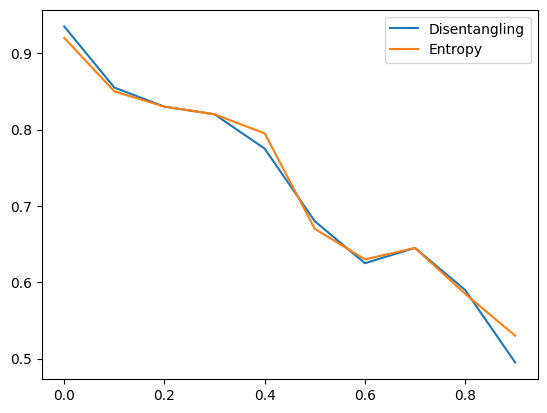

In [41]:
plt.plot(noises, disentangling_accuracies, label="Disentangling")
plt.plot(noises, entropy_accuracies, label="Entropy")
plt.legend()
plt.show()

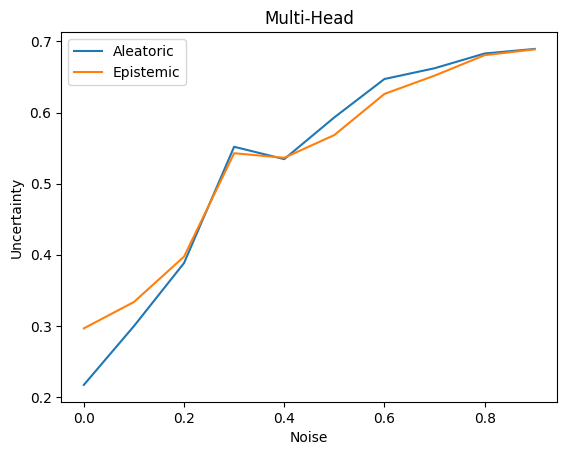

In [42]:
plt.plot(noises, disentangling_aleatorics, label="Aleatoric")
plt.plot(noises, disentangling_epistemics, label="Epistemic")
plt.title("Multi-Head")
plt.xlabel("Noise")
plt.ylabel("Uncertainty")
plt.legend()
plt.show()

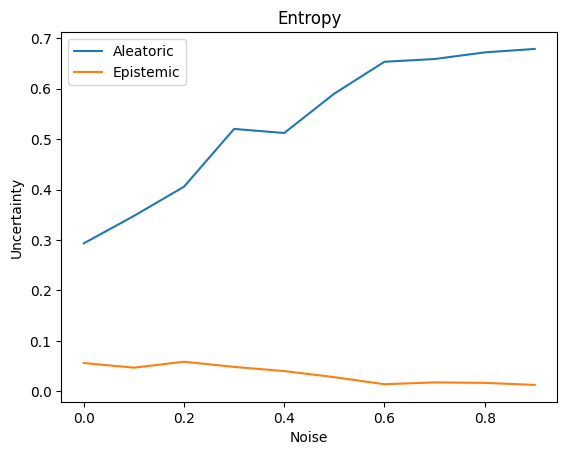

In [43]:
plt.plot(noises, entropy_aleatorics, label="Aleatoric")
plt.plot(noises, entropy_epistemics, label="Epistemic")
plt.title("Entropy")
plt.xlabel("Noise")
plt.ylabel("Uncertainty")
plt.legend()
plt.show()